<a href="https://colab.research.google.com/github/dmunozbe/TFM_DataScience/blob/main/Forecasting/08.%20Nou%20Barris/Forecasting_(Indicador_73).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Forecasting**




**Forecasting** es el proceso de predecir eventos futuros basados en patrones históricos y datos existentes.

El objetivo principal es el de hacer predicciones precisas sobre el futuro utilizando datos pasados y presentes y se utiliza en una amplia variaedad de constextos, como en finanzas, meteorologia, ventas entre otros

Se realizaran comprobaciones de cointegracion, estacionariedad, para determinar que modelo aplicar entre los seleccionados:

* Modelos VAR (Vector Autoregressive)
* Modelos VARMA (Vector Autoregressive Moving Average)
* Modelos VARMAx (VARMA con Variables Exógenas)
* Modelos VECM (Vector Error Correlation Model)

##Importar bibliotecas

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from sklearn import metrics


import warnings
warnings.filterwarnings("ignore")

##Carga de datos

In [2]:
# Cargar datos
data = pd.read_csv('/content/drive/MyDrive/UOC/TFM/Datasets definitivos/Final.csv')
data.head()

,Any,Trimestre,Mes,Codi_Districte,Nom_Districte,Codi_Barri,Nom_Barri,Compraventa_Unitario,ParadosReg,Estudios_Obligatorios,ConsumResidencial,Pm25,Pm10,Participacion,AñosEspVida,Internet,Movil,Index_Turisme,m² por habitante
0,2014,1,1,1,Ciutat Vella,1,el Raval,2813.0,4588,NaN,NaN,NaN,NaN,41.8,80.7,NaN,NaN,NaN,6.2
1,2014,1,2,1,Ciutat Vella,1,el Raval,2813.0,4539,NaN,NaN,NaN,NaN,41.8,80.7,NaN,NaN,NaN,6.2
2,2014,1,3,1,Ciutat Vella,1,el Raval,2813.0,4572,NaN,NaN,NaN,NaN,41.8,80.7,NaN,NaN,NaN,6.2
3,2014,2,4,1,Ciutat Vella,1,el Raval,2948.8,4510,NaN,NaN,NaN,NaN,41.8,80.7,NaN,NaN,NaN,6.2
4,2014,2,5,1,Ciutat Vella,1,el Raval,2948.8,4379,NaN,NaN,NaN,NaN,41.8,80.7,NaN,NaN,NaN,6.2


In [3]:
print(data.dtypes)

Any                        int64
Trimestre                  int64
Mes                        int64
Codi_Districte             int64
Nom_Districte             object
Codi_Barri                 int64
Nom_Barri                 object
Compraventa_Unitario     float64
ParadosReg                 int64
Estudios_Obligatorios    float64
ConsumResidencial        float64
Pm25                     float64
Pm10                     float64
Participacion            float64
AñosEspVida              float64
Internet                 float64
Movil                    float64
Index_Turisme            float64
m² por habitante         float64
dtype: object


## Analisis por grupo de indicadores (Internet)

### Preparacion de datos

In [4]:
df_sel = data[['Any','Trimestre','Mes','Codi_Districte','Nom_Districte','Codi_Barri','Nom_Barri','Compraventa_Unitario','Internet']]

In [5]:
df_cont = df_sel.dropna()

In [6]:
df_cont.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6132 entries, 1752 to 7883
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Any                   6132 non-null   int64  
 1   Trimestre             6132 non-null   int64  
 2   Mes                   6132 non-null   int64  
 3   Codi_Districte        6132 non-null   int64  
 4   Nom_Districte         6132 non-null   object 
 5   Codi_Barri            6132 non-null   int64  
 6   Nom_Barri             6132 non-null   object 
 7   Compraventa_Unitario  6132 non-null   float64
 8   Internet              6132 non-null   float64
dtypes: float64(2), int64(5), object(2)
memory usage: 479.1+ KB


In [7]:
# Creamos la variable de fecha de la siguiente manera:
# Agregar un día fijo para cada mes, por ejemplo, el día 1
df_cont['Fecha'] = pd.to_datetime(df_cont['Any'].astype(str) + '-' + df_cont['Mes'].astype(str) + '-1')

In [8]:
# Modificamos el indice del dataset por la fecha
df_contI = df_cont.set_index('Fecha')

In [9]:
df_contI.head()

,Any,Trimestre,Mes,Codi_Districte,Nom_Districte,Codi_Barri,Nom_Barri,Compraventa_Unitario,Internet
Fecha,,,,,,,,,
2016-01-01,2016,1,1,1,Ciutat Vella,1,el Raval,2813.0,82.8
2016-02-01,2016,1,2,1,Ciutat Vella,1,el Raval,2813.0,82.8
2016-03-01,2016,1,3,1,Ciutat Vella,1,el Raval,2813.0,82.8
2016-04-01,2016,2,4,1,Ciutat Vella,1,el Raval,2948.8,82.8
2016-05-01,2016,2,5,1,Ciutat Vella,1,el Raval,2948.8,82.8


### Analisis Exploratorio

Filtramos los datos por el distrito de Nou Barris -> Codi_Districte = 8

In [10]:
df_contFiltrado = df_contI[df_contI['Codi_Districte'] == 8]

In [11]:
# Agrupamos los datos
df =df_contFiltrado.drop(columns=['Any','Trimestre','Mes','Codi_Districte','Nom_Districte','Codi_Barri','Nom_Barri']).groupby('Fecha').mean()

In [12]:
df.head()

,Compraventa_Unitario,Internet
Fecha,,
2016-01-01,1511.900000,71.5
2016-02-01,1511.900000,71.5
2016-03-01,1511.900000,71.5
2016-04-01,1633.069231,71.5
2016-05-01,1633.069231,71.5


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 84 entries, 2016-01-01 to 2022-12-01
Data columns (total 2 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Compraventa_Unitario  84 non-null     float64
 1   Internet              84 non-null     float64
dtypes: float64(2)
memory usage: 2.0 KB


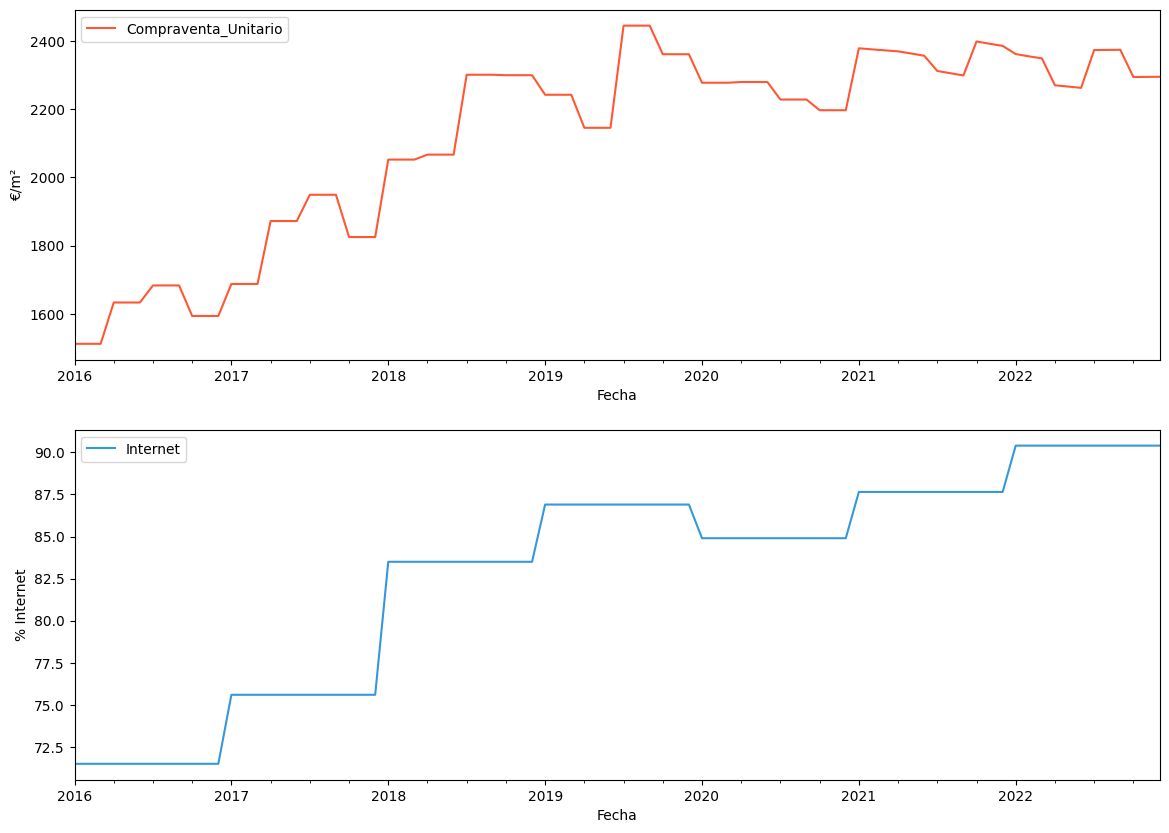

In [14]:
fig, axes = plt.subplots(nrows = int(len(df.columns)), ncols = 1, dpi = 100, figsize = (14,10))
unidades = ['€/m²', '% Internet']
colores = ['#FF5733', '#3498DB']

for i, (col,ax) in enumerate(zip(df.columns, axes.flatten())):
    df[col].plot(color = colores[i], legend = True, ax = ax)
    ax.set_ylabel(unidades[i])  # Establecer etiqueta del eje y
plt.show()

Cada una de las series tiene patrones de tendencia muy diferentes entre si

In [15]:
corr=df.corr()
corr

,Compraventa_Unitario,Internet
Compraventa_Unitario,1.000000,0.939532
Internet,0.939532,1.000000


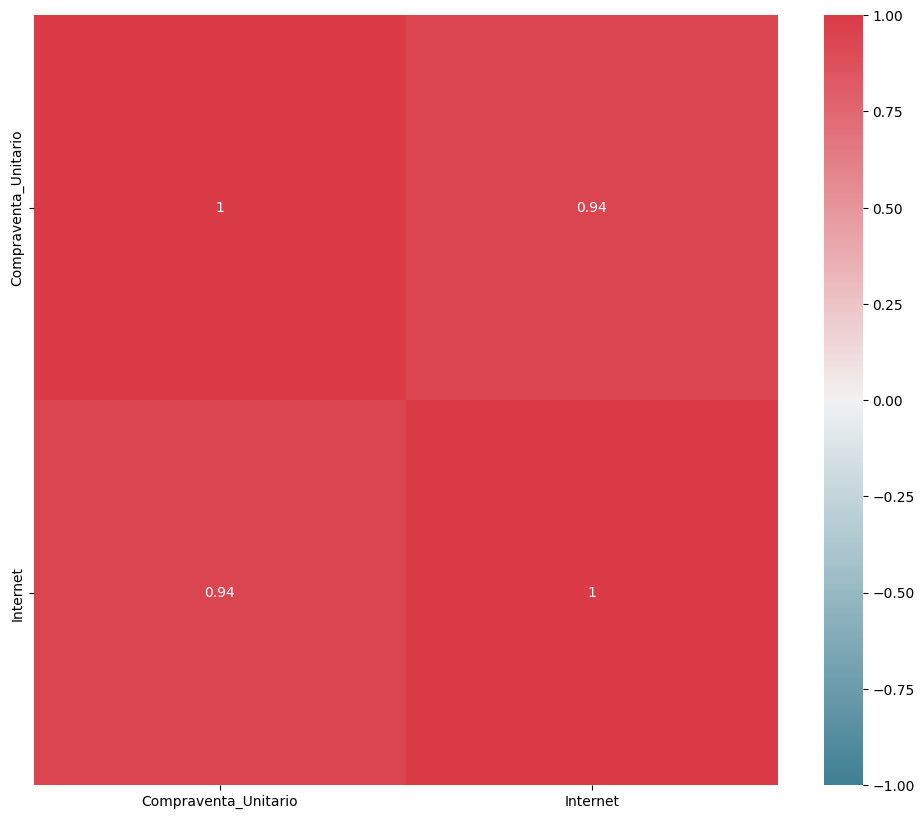

In [16]:
import seaborn as sb
fig, ax = plt.subplots(figsize=(12, 10))

sb.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values, annot=True,vmax=1, vmin=-1, cmap =sb.diverging_palette(220, 10, as_cmap=True),center=0,ax=ax )
plt.show()

La correlación entre "Compraventa_Unitario" y "Internet" es de 0.939532, lo que sugiere una correlación muy alta entre estas dos variables en el modelo.

### Dividir los datos en conjunto de Entrenamiento y Prueba


In [20]:
fecha_division = '2022-01-01'

X_train, X_test = df[df.index<fecha_division], df[df.index>=fecha_division]
print(X_train.shape, X_test.shape)


(72, 2) (12, 2)


Los modelos siguientes se ajustarán al conjunto de entrenamiento X_train y luego se utilizará el modelo para pronosticar las observaciones futuras. Estos pronósticos se compararán con los datos reales del conjunto de prueba.



###Test de Cointegracion

Determinaremos si las dos variables estan relacionadas entre si y si esa relacion es duradera o no

In [18]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

def cointegration_test(df):
    res = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = res.lr1
    cvts = res.cvt[:, d[str(1-0.05)]]
    def adjust(val, length= 6):
        return str(val).ljust(length)
    print('Column Name   >  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), '> ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

In [21]:
cointegration_test(X_train[['Compraventa_Unitario', 'Internet']])

Column Name   >  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
Compraventa_Unitario >  13.72     > 12.3212   =>   True
Internet >  1.12      > 4.1296    =>   False


- **Compraventa_Unitario** muestra evidencia de cointegración, lo que sugiere que las variables incluidas tienen una tendencia a largo plazo a moverse juntas, manteniendo una relación de equilibrio.
- **Internet** no muestra evidencia de cointegración, lo que significa que las series relacionadas no tienden a volver a un equilibrio común a largo plazo bajo el modelo actual.

Para un análisis conjunto, dado que una de las series esta cointegrada y la otra no, se consideran principalmente 2 modelos, VAR y VECM

### Prueba de estacionariedad

Necesitamos que los datos sean estacionarios para poder usar el modelo VAR. Vamos a averiguarlo haciendo un Test de Dickey-Fuller aumentado, a cada variable univariante que tiene nuestro dataset.

In [22]:
import statsmodels.tsa.stattools as sts

In [23]:
def augmented_dickey_fuller_statistics(time_series):
  result = sts.adfuller(time_series.values)
  print('p-value: %f' % result[1])

print('Test de Dickey-Fuller Aumentado:')
for i in range(len(X_train.columns)):
  print('Serie de tiempo',X_train.columns[i])
  augmented_dickey_fuller_statistics(X_train.iloc[:,i])

Test de Dickey-Fuller Aumentado:
Serie de tiempo Compraventa_Unitario
p-value: 0.394307
Serie de tiempo Internet
p-value: 0.581953


Los p-valores son mayores que 0.05, con lo cual no se rechaza la hipótesis nula de que la serie no es estacionaria. Habría que transformar los datos porque no se puede confirmar estacionariedad.

In [24]:
#Diferenciando por primera vez
X_train_transformed=X_train.diff().dropna()
X_train_transformed.head()

,Compraventa_Unitario,Internet
Fecha,,
2016-02-01,0.000000,0.0
2016-03-01,0.000000,0.0
2016-04-01,121.169231,0.0
2016-05-01,0.000000,0.0
2016-06-01,0.000000,0.0


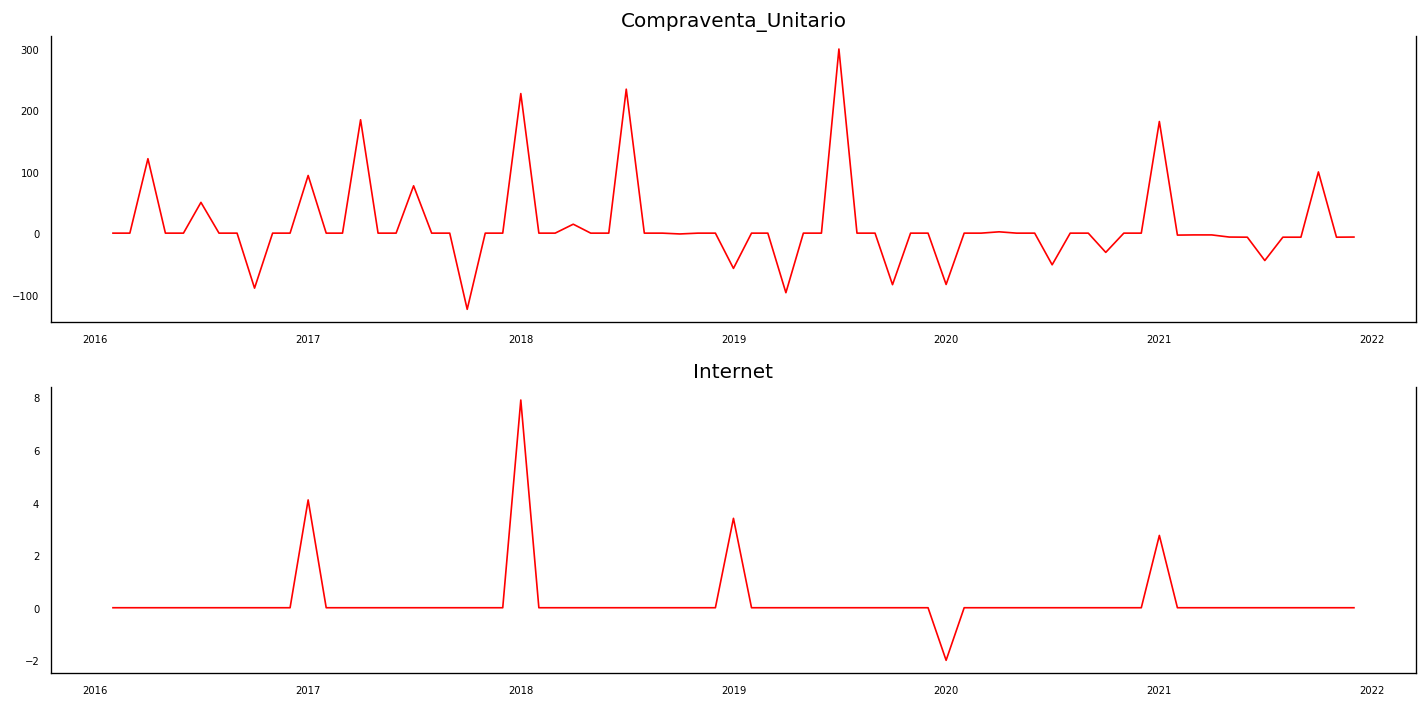

In [25]:
# Plot
fig, axes = plt.subplots(nrows=2, ncols=1, dpi=120, figsize=(12,6))
for i, ax in enumerate(axes.flatten()):
    data = X_train_transformed[X_train_transformed.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    # Decorations
    ax.set_title(X_train_transformed.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

In [26]:
print('Test de Dickey-Fuller Aumentado 2da vez:')
for i in range(len(X_train_transformed.columns)):
  print('Serie de tiempo transformada', 'Variable', X_train_transformed.columns[i])
  augmented_dickey_fuller_statistics(X_train_transformed.iloc[:,i])

Test de Dickey-Fuller Aumentado 2da vez:
Serie de tiempo transformada Variable Compraventa_Unitario
p-value: 0.000000
Serie de tiempo transformada Variable Internet
p-value: 0.000000


Todos los p-valores son < 0.05 por lo tanto se podría concluir que con 1 orden de diferenciación se obtienen series estacionarias.

### Modelo VAR

El modelo VAR es una extension del modelo ARIMA para multiples series temporales, es decir en vez de modelar una sola srie temporal, el VAR modela simultaneamente todas las series temporales de un sistema.
Cada serie temporal se regresa en función de usus propios valores pasados y de los valores pasados de las otras series temporales.
**Es util cuando las diferentes series temporales estan interrelacionadas y se influyen mutuamente.**




In [27]:
from statsmodels.tsa.api import VAR

In [28]:
model = VAR(X_train_transformed)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


#### Seleccionando el orden del modelo

In [48]:
modelsel=model.select_order(8)
modelsel.summary()

,AIC,BIC,FPE,HQIC
0,8.886,8.954*,7233.,8.913
1,9.011,9.215,8194.,9.091
2,9.135,9.476,9284.,9.269
3,9.150,9.626,9427.,9.337
4,9.272,9.884,1.068e+04,9.513
5,9.393,10.14,1.210e+04,9.688
6,8.437*,9.321,4668.*,8.784*
7,8.558,9.579,5308.,8.960
8,8.679,9.836,6041.,9.134


Dado que el AIC, FPE y HQIC alcanzan sus valores mínimos en el orden 6, y que el BIC es el único que destaca el orden 0, generalmente se prefiere seguir la mayoría de los criterios, especialmente en presencia de una fuerte señal en AIC, FPE y HQIC. Esto sugiere que el modelo VAR de orden 6 es el más adecuado para los datos, proporcionando un buen equilibrio entre ajuste del modelo y penalización por aumentar la complejidad del modelo.

#### Ajustando el modelo

In [49]:
res = model.fit(maxlags=6)
res.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 15, May, 2024
Time:                     12:32:39
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    9.21965
Nobs:                     65.0000    HQIC:                   8.69307
Log likelihood:          -429.833    FPE:                    4276.21
AIC:                      8.34989    Det(Omega_mle):         2969.59
--------------------------------------------------------------------
Results for equation Compraventa_Unitario
                             coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------------------
const                          10.831981         8.115005            1.335           0.182
L1.Compraventa_Unitario        -0.017360         0.104775           -0.166           0.868
L1.In

La correlación entre los residuos de "Compraventa_Unitario" y los residuos de "Internet" es de 0.640013, lo que sugiere una correlación moderada entre los residuos de estas dos variables en el modelo.

In [50]:
res.is_stable()

True

In [51]:
X_train.columns

Index(['Compraventa_Unitario', 'Internet'], dtype='object')

###### Causalidad de Granger

In [52]:
grangercaus=res.test_causality(['Internet'],['Compraventa_Unitario'],kind='f')
grangercaus.summary()

Test statistic,Critical value,p-value,df
0.7699,2.187,0.595,"(6, 104)"


In [53]:
grangercaus=res.test_causality(['Compraventa_Unitario'],['Internet'],kind='f')
grangercaus.summary()

Test statistic,Critical value,p-value,df
8.974,2.187,0.000,"(6, 104)"


Como se puede observar, la causalidad de Granger nos indica que ninguna de las series temporales puede predecir la otra serie temporal

###### Matriz de causalidad de Granger


In [54]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import grangercausalitytests
import warnings
warnings.filterwarnings("ignore")
maxlag=21
test = 'ssr_chi2test'
def grangers_causality_matrix(X_train_transformed, variables, test = 'ssr_chi2test', verbose=False):
  dataset = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
  for c in dataset.columns:
    for r in dataset.index:
      test_result = grangercausalitytests(X_train_transformed[[r,c]], maxlag=maxlag, verbose=False)
      p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
      if verbose:
        print(f'Y = {r}, X = {c}, P Values = {p_values}')
      min_p_value = np.min(p_values)
      dataset.loc[r,c] = min_p_value
  dataset.columns = [var + '_x' for var in variables]
  dataset.index = [var + '_y' for var in variables]
  return dataset
grangers_causality_matrix(X_train_transformed, variables = X_train_transformed.columns)

,Compraventa_Unitario_x,Internet_x
Compraventa_Unitario_y,1.0,0.0
Internet_y,0.0,1.0


Con esta matriz queda claro que la serie temporal de Compraventa_Unitario no causa ni es causada por la otra serie temporal de ParadosReg

###### Diagnosis del modelo


###### Residuos

In [55]:
residuals=res.resid

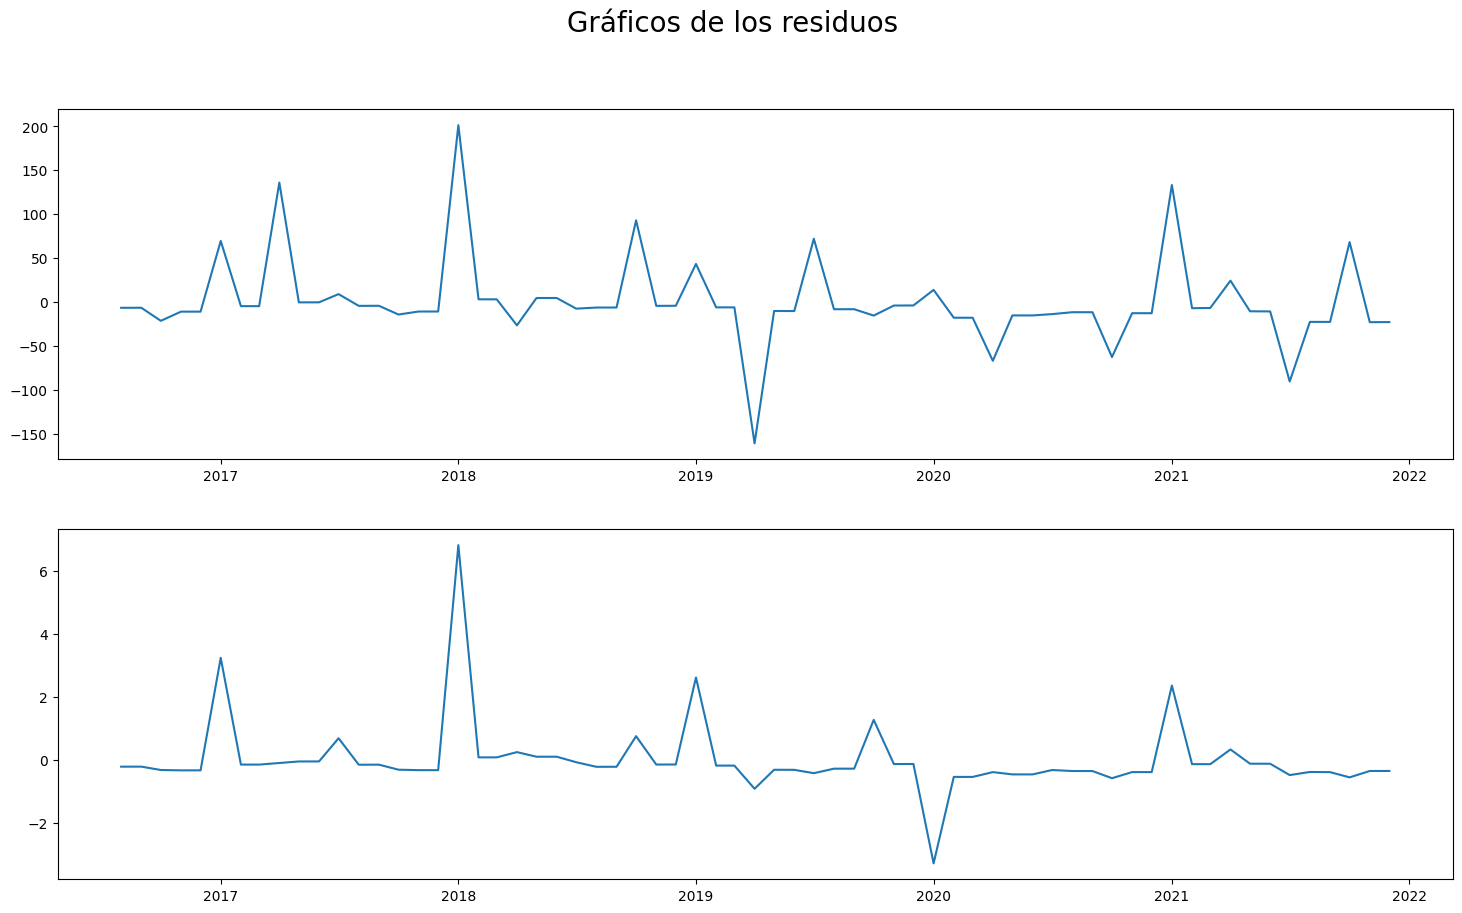

In [56]:
fig, axs = plt.subplots(2)
fig.suptitle('Gráficos de los residuos',fontsize=20)
fig.set_size_inches(18, 10)
[axs[i].plot(residuals.iloc[:,i]) for i in range(2)]
plt.show()

###### Dickey - Fuller a los residuos


In [57]:
print('ADF de los Residuos, p-valores:')
[sts.adfuller(residuals.iloc[:,i])[1] for i in range(2)]

ADF de los Residuos, p-valores:


[0.6174708391694577, 6.139559190698218e-12]

Todos los p-valores son < 0.1 por tanto se rechaza la hipótesis nula de que las 3 series de residuos no son estacionarias, por lo cual con un 90% de confianza se cree que son estacionarias.



###### ACF de los Residuos


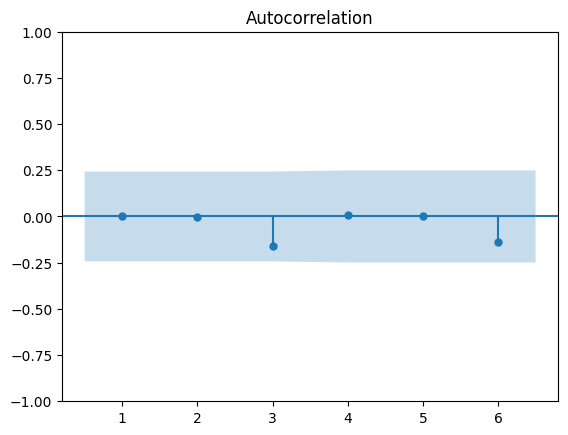

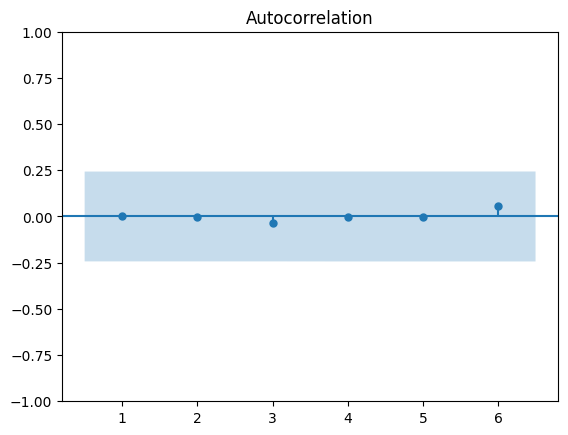

In [58]:
import statsmodels.graphics.tsaplots as sgt
[sgt.plot_acf(residuals.iloc[:,i], zero = False, lags = 6) for i in range(2)]
plt.show()

Se observa que casi los puntos están dentro del intervalo de confianza hasta el rezago 6, lo que sugiere que no hay autocorrelaciones significativas para esos rezagos. Esto es un buen indicio y sugiere que el modelo está adecuadamente especificado para estos rezagos.

#### Valores predichos


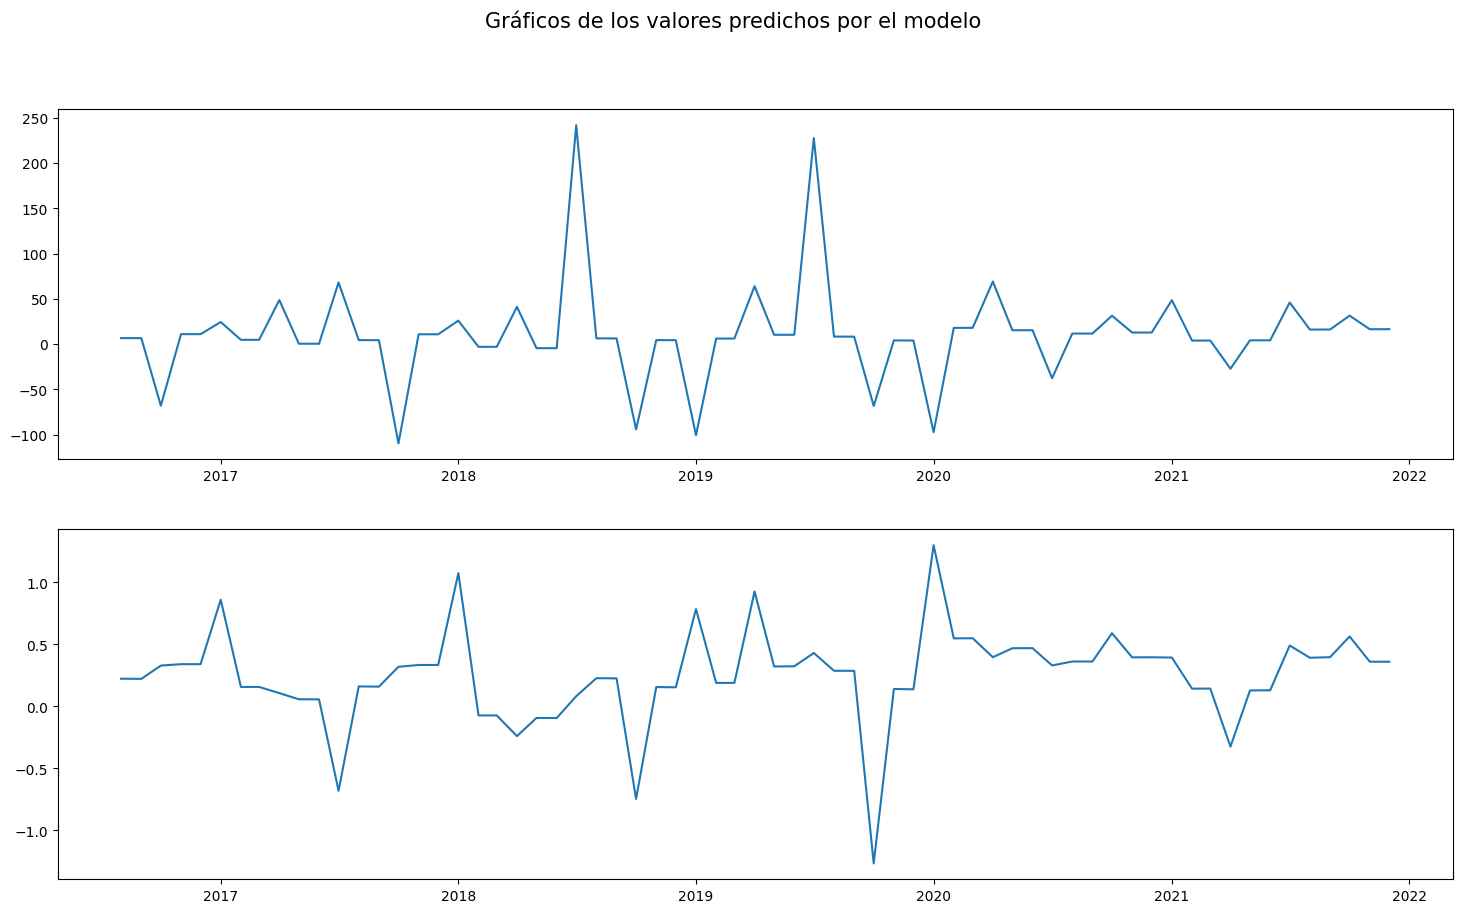

In [59]:
y_fitted = res.fittedvalues
fig, axs = plt.subplots(2)
fig.suptitle('Gráficos de los valores predichos por el modelo',fontsize=15)
fig.set_size_inches(18, 10)
[axs[i].plot(y_fitted.iloc[:,i]) for i in range(2)]
plt.show()

#### Pronósticos a futuro


In [60]:
# Obtener el orden del modelo
lag_order = res.k_ar
print('Orden del modelo:', lag_order)
# Input data para hacer forecasting (pronósticos a futuro)
input_data = X_train_transformed.values[-lag_order:]
# Forecasting
pred = res.forecast(y=input_data, steps=12)
pred = (pd.DataFrame(pred, index=X_test.index, columns=X_test.columns + '_pred'))
print('Predicciones:')
pred

Orden del modelo: 6
Predicciones:


,Compraventa_Unitario_pred,Internet_pred
Fecha,,
2022-01-01,-9.007570,-0.200616
2022-02-01,14.807414,0.303212
2022-03-01,13.795688,0.276228
2022-04-01,-35.823963,0.518561
2022-05-01,10.012570,0.272448
2022-06-01,9.273395,0.250917
2022-07-01,23.061565,0.481159
2022-08-01,13.030846,0.262297
2022-09-01,12.505934,0.265305


<Figure size 1200x1000 with 0 Axes>

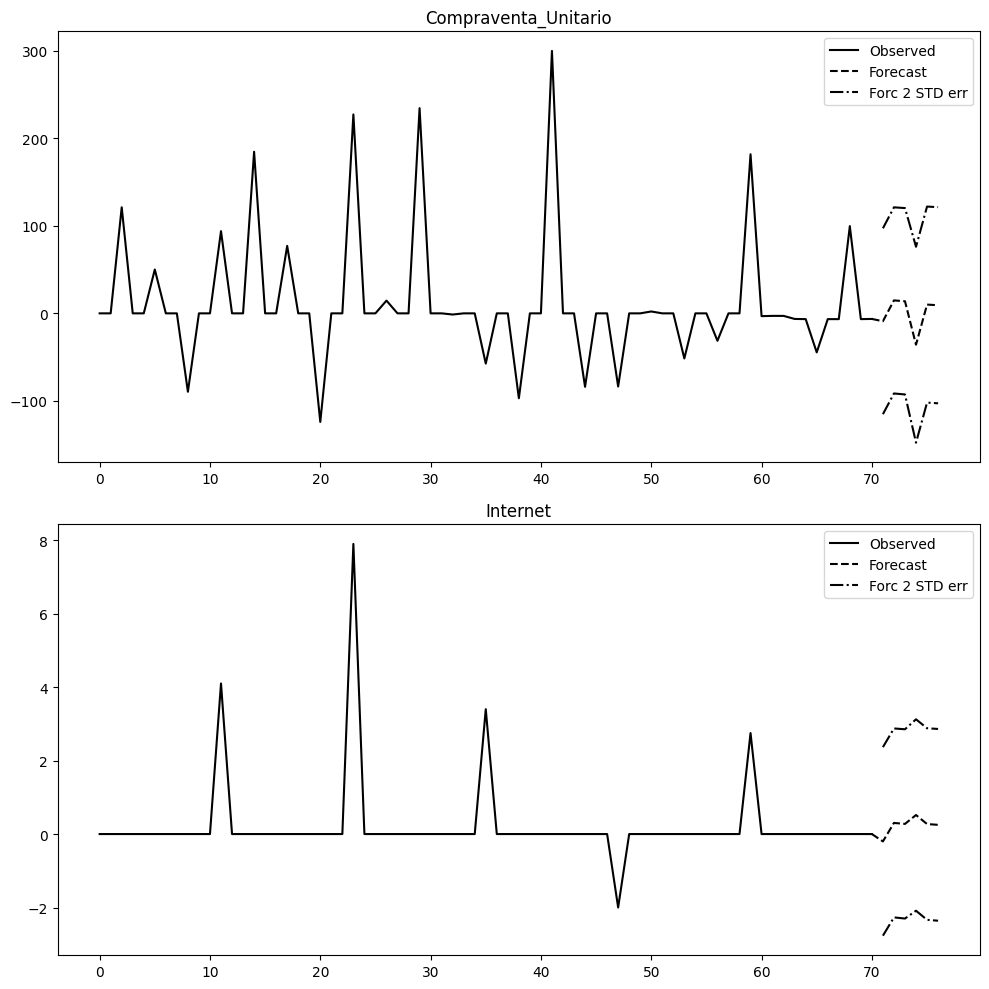

In [61]:
import matplotlib.pyplot as plt
plt.figure(figsize = (12, 10))
res.plot_forecast(lag_order)
plt.tight_layout(h_pad = 1.15)
plt.show()


#### Invirtiendo la transformación de los pronósticos a la escala original


Los pronósticos se generan en la escala de los datos de entrenamiento utilizados por el modelo, es decir, son datos transformados. Entonces, para volver a ponerlos en su escala original, necesitamos des-diferenciarlos. La forma de invertir la diferenciación es sumar estas diferencias consecutivamente al número base. Una forma sencilla de hacerlo es determinar primero la suma acumulada y luego sumarla al número base. Este proceso se puede revertir agregando la observación en el paso de tiempo anterior al difference value. inverted(ts) = differenced(ts) + observation(ts-1)



In [62]:
# Invirtiendo la transformación teniendo en cuenta que hemos diferenciado dos veces
def invert_transformation(ds, df_forecast, second_diff=False):
    for col in ds.columns:
        # Undo the 2nd Differencing
        if second_diff:
            df_forecast[str(col)] = (ds[col].iloc[-1] - ds[col].iloc[-2]) + df_forecast[str(col)].cumsum()

        # Undo the 1st Differencing
        df_forecast[str(col)] = ds[col].iloc[-1] + df_forecast[str(col)].cumsum()

    return df_forecast

In [63]:
pred.columns=X_test.columns
output = invert_transformation(X_train, pred, second_diff=False)
output

,Compraventa_Unitario,Internet
Fecha,,
2022-01-01,2376.736240,87.449384
2022-02-01,2391.543654,87.752596
2022-03-01,2405.339342,88.028824
2022-04-01,2369.515379,88.547385
2022-05-01,2379.527949,88.819833
2022-06-01,2388.801344,89.070750
2022-07-01,2411.862910,89.551910
2022-08-01,2424.893756,89.814207
2022-09-01,2437.399690,90.079511


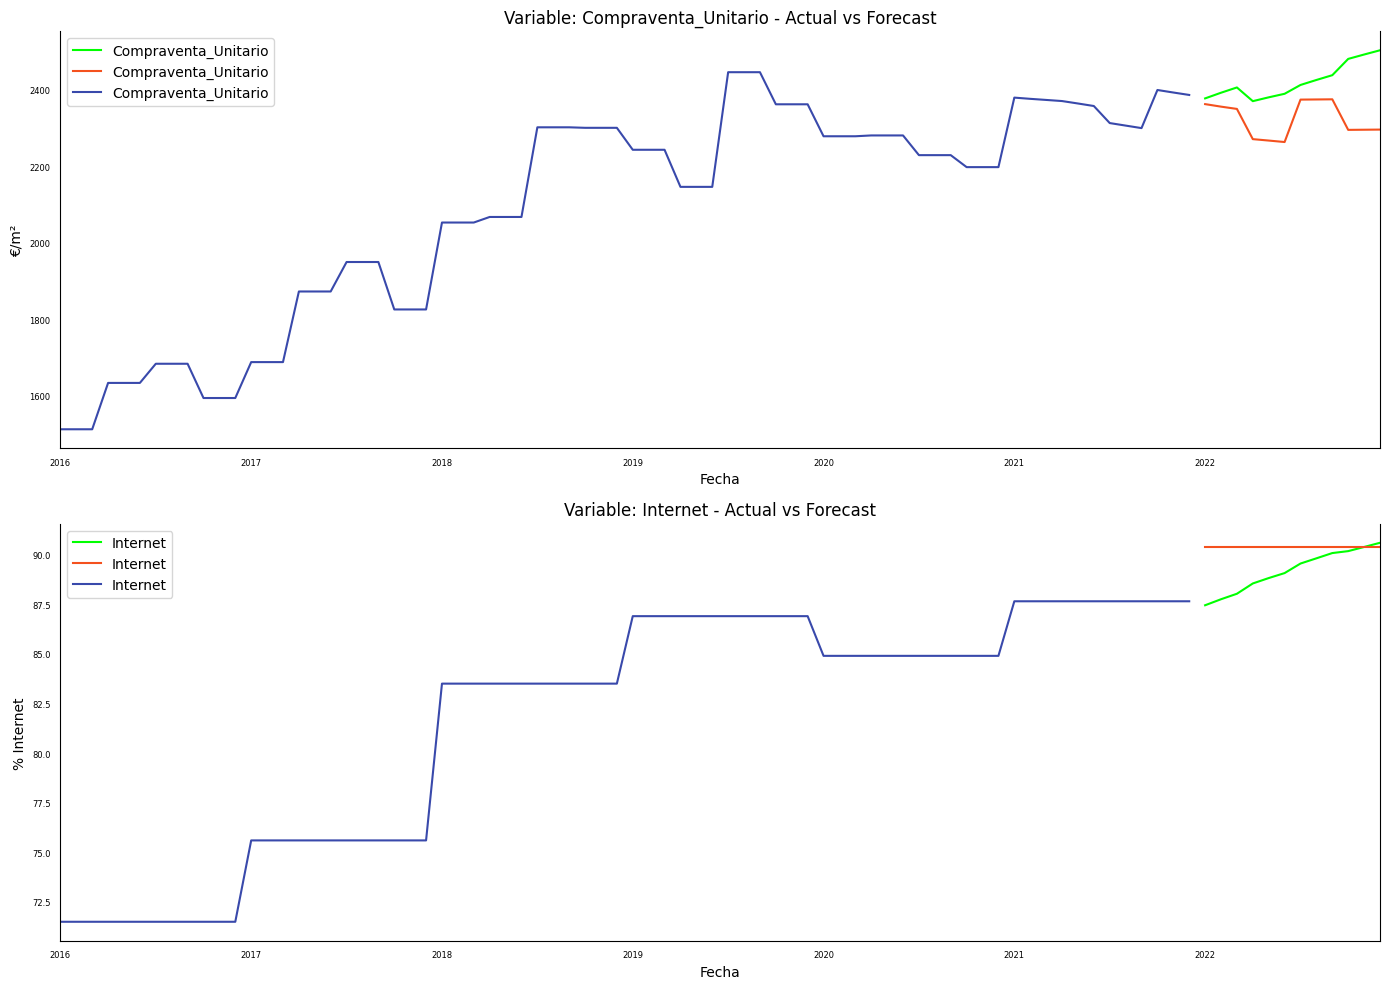

In [64]:
# Actual vs Forecasted Plots
fig, axes = plt.subplots(nrows = int(len(X_train.columns)), ncols = 1, dpi = 100, figsize = (14,10))
mi_lista = ['€/m²', '% Internet']

for i, (col,ax) in enumerate(zip(X_train.columns, axes.flatten())):
    output[col].plot(color = '#00FF00', legend = True, ax = ax).autoscale(axis =' x',tight = True)
    X_test[col].plot(color = '#F4511E', legend = True, ax = ax)
    X_train[col].plot(color = '#3949AB', legend = True, ax = ax)

    ax.set_title('Variable: ' + col + ' - Actual vs Forecast')
    ax.set_ylabel(mi_lista[i])  # Establecer etiqueta del eje y
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')

    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize = 6)

plt.tight_layout()
plt.savefig('actual_forecast.png')
plt.show()

#### Evaluando el modelo


In [65]:
def timeseries_evaluation_metrics_func(y_true, y_pred):

    def mean_absolute_percentage_error(y_true, y_pred):
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print('Evaluation metric results:-')
    print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)}')
    print(f'R2 is : {metrics.r2_score(y_true, y_pred)}',end='\n\n')

In [66]:
for i in ['Compraventa_Unitario','Internet']:
    print(f'Evaluation metric for {i}')
    timeseries_evaluation_metrics_func(X_test[str(i)] , output[str(i)])

Evaluation metric for Compraventa_Unitario
Evaluation metric results:-
MSE is : 13939.850629149814
MAE is : 98.95265102188118
RMSE is : 118.06714457947145
MAPE is : 4.299397844699718
R2 is : -6.271738501086411

Evaluation metric for Internet
Evaluation metric results:-
MSE is : 2.5239475103954496
MAE is : 1.2433439146707006
RMSE is : 1.5886936490070858
MAPE is : 1.375380436582633
R2 is : -1.2497982720692723e+28




Los resultados de evaluación para Compraventa_Unitario muestran un modelo ineficaz, con un R² extremadamente negativo de -6.27, lo que indica que el modelo es considerablemente peor que uno que solo utiliza la media de los datos. Los valores elevados de MSE, MAE, y RMSE refuerzan la falta de precisión del modelo, aunque el MAPE de 4.30% sugiere una precisión relativa moderada.

Para Internet, los errores cuantitativos como MSE, MAE y RMSE son bajos, pero el R² es extremadamente negativo, alcanzando un valor de aproximadamente -1.25x10^28, lo cual es inusual y posiblemente indica un error en el cálculo o un problema grave de sobreajuste o especificación incorrecta del modelo. El MAPE de 1.38% muestra precisión pero debe ser interpretado con cautela dada la anomalía en R².

In [67]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
print('Mean absolute error:', mean_absolute_error(X_test, output))
print('Root mean squared error:', np.sqrt(mean_squared_error(X_test, output)))

Mean absolute error: 50.09799746827594
Root mean squared error: 83.49363621456492


### Modelo VECM (Vector Error Correction Model

In [68]:
!pip install statsmodels==0.14.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 21.4 MB/s eta 0:00:00
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.14.2
    Uninstalling statsmodels-0.14.2:
      Successfully uninstalled statsmodels-0.14.2


#### Ajustando el modelo

In [69]:
from statsmodels.tsa.vector_ar.vecm import select_order

In [70]:
# Seleccionar el número óptimo de retardos basado en criterios de información
order_selection = select_order(X_train, maxlags=8) #Dado que una de las series tiene datos trimestrales(8) y la otra anual(30)
print(order_selection.summary())

 VECM Order Selection (* highlights the minimums)
      AIC         BIC         FPE         HQIC   
-------------------------------------------------
0       8.748      8.952*       6296.       8.828
1       8.823       9.163       6792.       8.957
2       8.864       9.340       7085.       9.051
3       8.877       9.490       7195.       9.118
4       8.838       9.586       6939.       9.132
5       8.467       9.352       4814.       8.815
6      8.263*       9.283      3950.*      8.664*
7       8.326       9.483       4246.       8.781
8       8.347       9.640       4385.       8.856
-------------------------------------------------


In [71]:
from statsmodels.tsa.vector_ar.vecm import VECM

In [72]:
# Usar el número óptimo de retardos seleccionado
optimal_lags = order_selection.aic  # Por ejemplo, puedes usar el criterio AIC
model = VECM(X_train, k_ar_diff=optimal_lags, coint_rank=1)

In [73]:
vecm_fit = model.fit()

In [74]:
vecm_fit.summary()

,coef,std err,z,P>|z|,[0.025,0.975]
L1.Compraventa_Unitario,0.0364,0.091,0.398,0.690,-0.143,0.215
L1.Internet,-5.4501,5.623,-0.969,0.332,-16.472,5.571
L2.Compraventa_Unitario,0.0362,0.091,0.396,0.692,-0.143,0.215
L2.Internet,-5.4483,5.624,-0.969,0.333,-16.471,5.575
L3.Compraventa_Unitario,-0.3675,0.093,-3.954,0.000,-0.550,-0.185
L3.Internet,4.6793,5.655,0.827,0.408,-6.404,15.762
L4.Compraventa_Unitario,-0.0138,0.092,-0.151,0.880,-0.193,0.166
L4.Internet,-3.7003,5.420,-0.683,0.495,-14.323,6.923
L5.Compraventa_Unitario,-0.0141,0.092,-0.154,0.877,-0.194,0.165
L5.Internet,-3.7114,5.421,-0.685,0.494,-14.337,6.914


El análisis indica que las dos series están cointegradas y tienen una relación dinámica de ajuste hacia un equilibrio común. Los resultados sugieren que ajustes en "Internet" tienen un efecto significativo en "Compraventa_Unitario", mientras que los ajustes en "Compraventa_Unitario" tienen un impacto relativamente menor en "Internet" basado en los coeficientes de carga más pequeños.

In [75]:
stability_test = vecm_fit.test_whiteness(nlags=12)
print(stability_test.summary())

Portmanteau-test for residual autocorrelation. H_0: residual autocorrelation up to lag 12 is zero. Conclusion: reject H_0 at 5% significance level.
Test statistic Critical value p-value df
----------------------------------------
         39.38          33.92   0.013 22
----------------------------------------


#### Diagnosis del modelo

##### Residuos

In [76]:
residuals=vecm_fit.resid

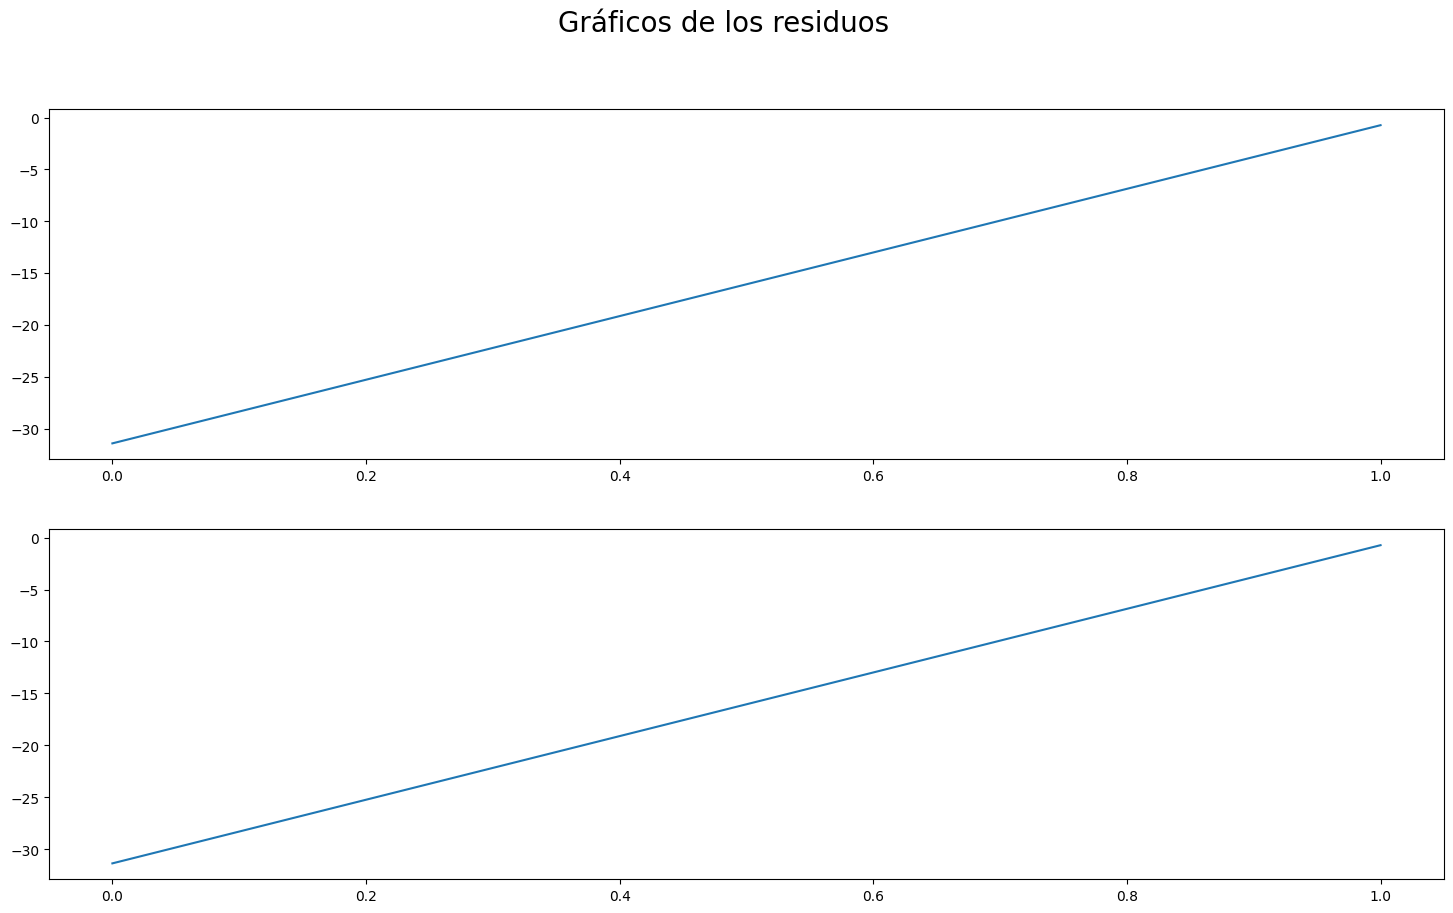

In [77]:
fig, axs = plt.subplots(2)
fig.suptitle('Gráficos de los residuos',fontsize=20)
fig.set_size_inches(18, 10)
[axs[i].plot(residuals[i]) for i in range(2)]
plt.show()

#####Dickey - Fuller a los residuos

In [78]:
import statsmodels.tsa.stattools as ts

In [79]:
# Realizar la prueba ADF en cada serie de residuos y imprimir los resultados
print('ADF de los Residuos, p-valores:')
for i in range(residuals.shape[1]):
    result = ts.adfuller(residuals[:, i])
    print(f'Variable {i+1}: Estadístico ADF = {result[0]:.4f}, P-valor = {result[1]:.4f}')

ADF de los Residuos, p-valores:
Variable 1: Estadístico ADF = -1.4920, P-valor = 0.5375
Variable 2: Estadístico ADF = -7.9025, P-valor = 0.0000


#####ACF de los Residuos

In [80]:
import statsmodels.api as sm

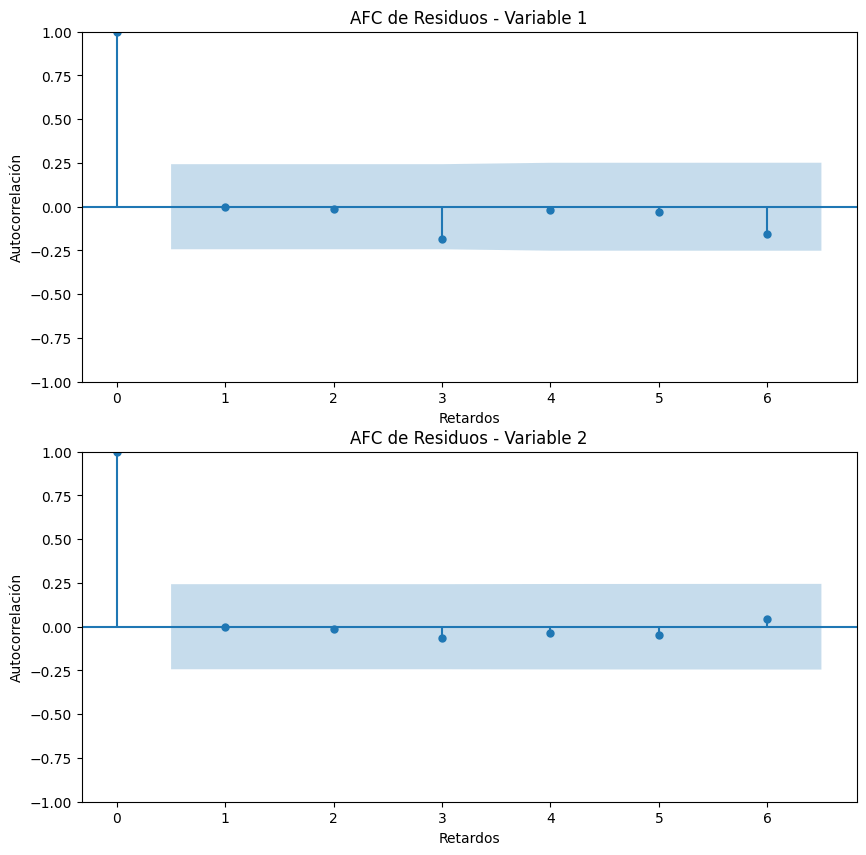

In [81]:
# Realizar y graficar la función de autocorrelación para cada serie de residuos
fig, axes = plt.subplots(nrows=residuals.shape[1], ncols=1, figsize=(10, 10))
for i in range(residuals.shape[1]):
    sm.graphics.tsa.plot_acf(residuals[:, i], lags=6, ax=axes[i], title=f'AFC de Residuos - Variable {i+1}')
    axes[i].set_ylabel('Autocorrelación')
    axes[i].set_xlabel('Retardos')

Esto sugiere que los residuos de la Variable 1 y 2 son aproximadamente ruido blanco, indicando un buen ajuste del modelo para esta variable. No hay evidencia de autocorrelaciones remanentes que el modelo no haya capturado.

####Valores predichos

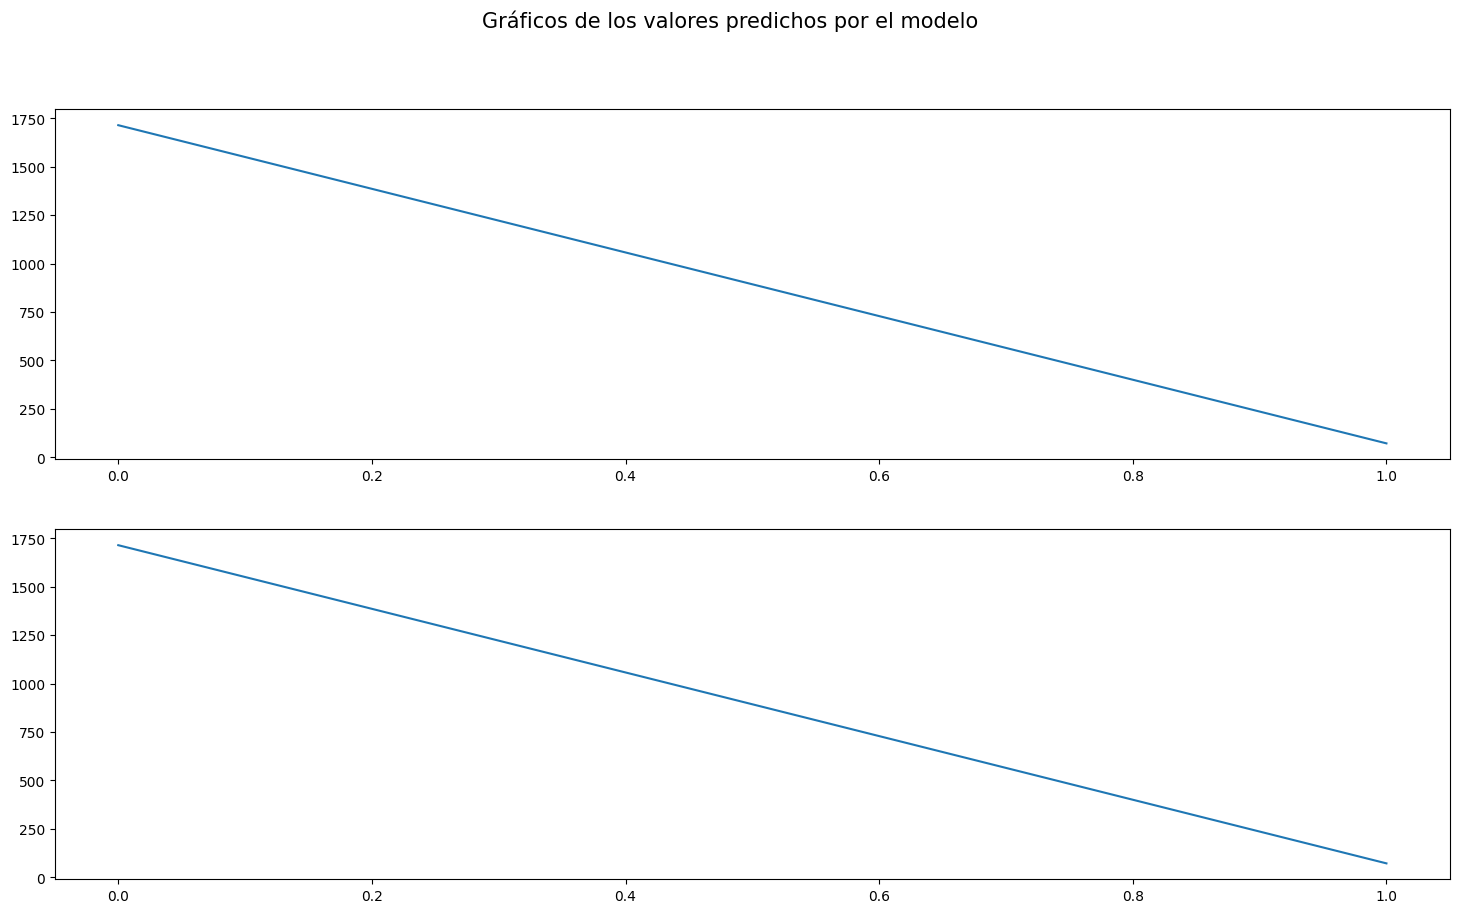

In [82]:
y_fitted = vecm_fit.fittedvalues
fig, axs = plt.subplots(2)
fig.suptitle('Gráficos de los valores predichos por el modelo',fontsize=15)
fig.set_size_inches(18, 10)
[axs[i].plot(y_fitted[i]) for i in range(2)]
plt.show()

####Pronósticos a futuro

In [83]:
# Obtener los últimos valores (lag_order número de valores)
lag_order = vecm_fit.k_ar
last_observations = data[-lag_order:]

# Hacer predicciones para los próximos n pasos
n_steps = 12
forecast = vecm_fit.predict(n_steps)

pred = (pd.DataFrame(forecast, index=X_test.index, columns=X_test.columns))
pred

,Compraventa_Unitario,Internet
Fecha,,
2022-01-01,2370.461096,87.208579
2022-02-01,2377.591212,87.256650
2022-03-01,2384.165438,87.294465
2022-04-01,2341.717995,87.584991
2022-05-01,2347.054507,87.648512
2022-06-01,2351.498390,87.692826
2022-07-01,2361.677263,87.969000
2022-08-01,2361.486662,88.028163
2022-09-01,2361.263967,88.086988


<Figure size 1200x1000 with 0 Axes>

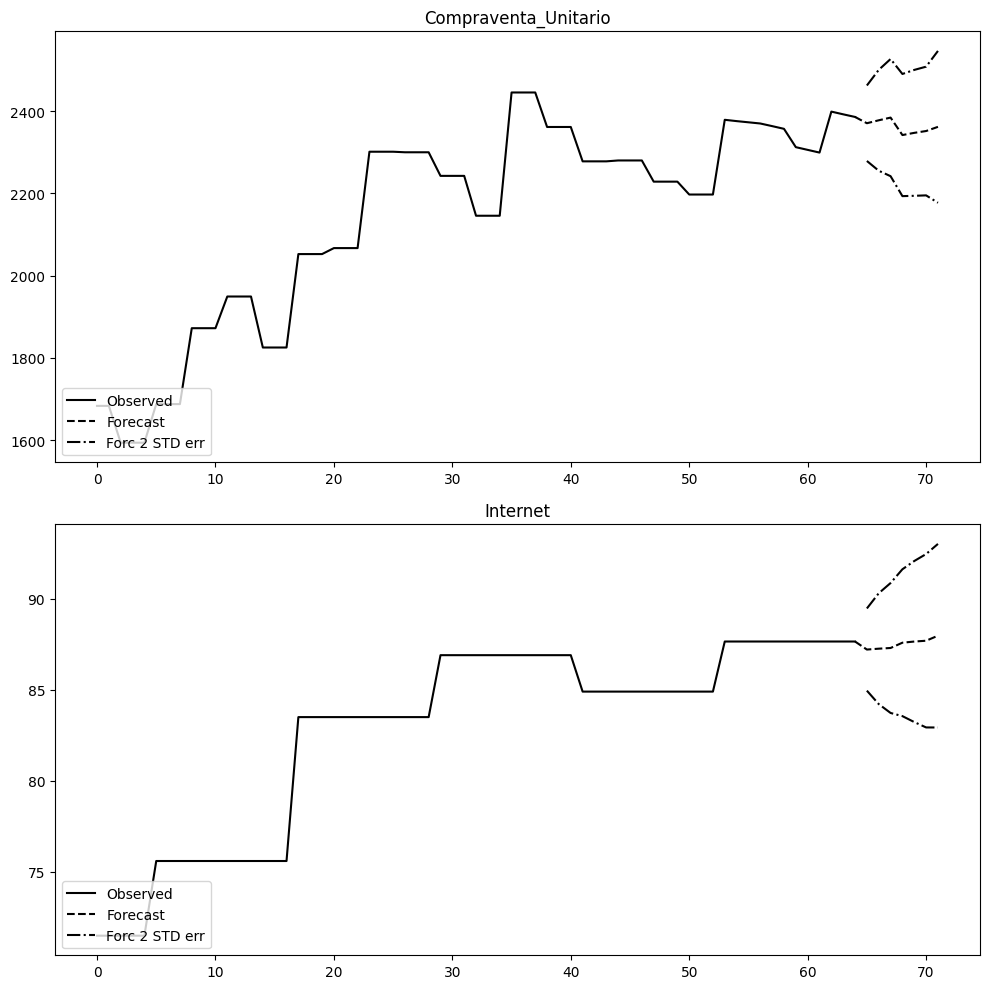

In [84]:
import matplotlib.pyplot as plt
plt.figure(figsize = (12, 10))
vecm_fit.plot_forecast(lag_order)
plt.tight_layout(h_pad = 1.15)
plt.show()

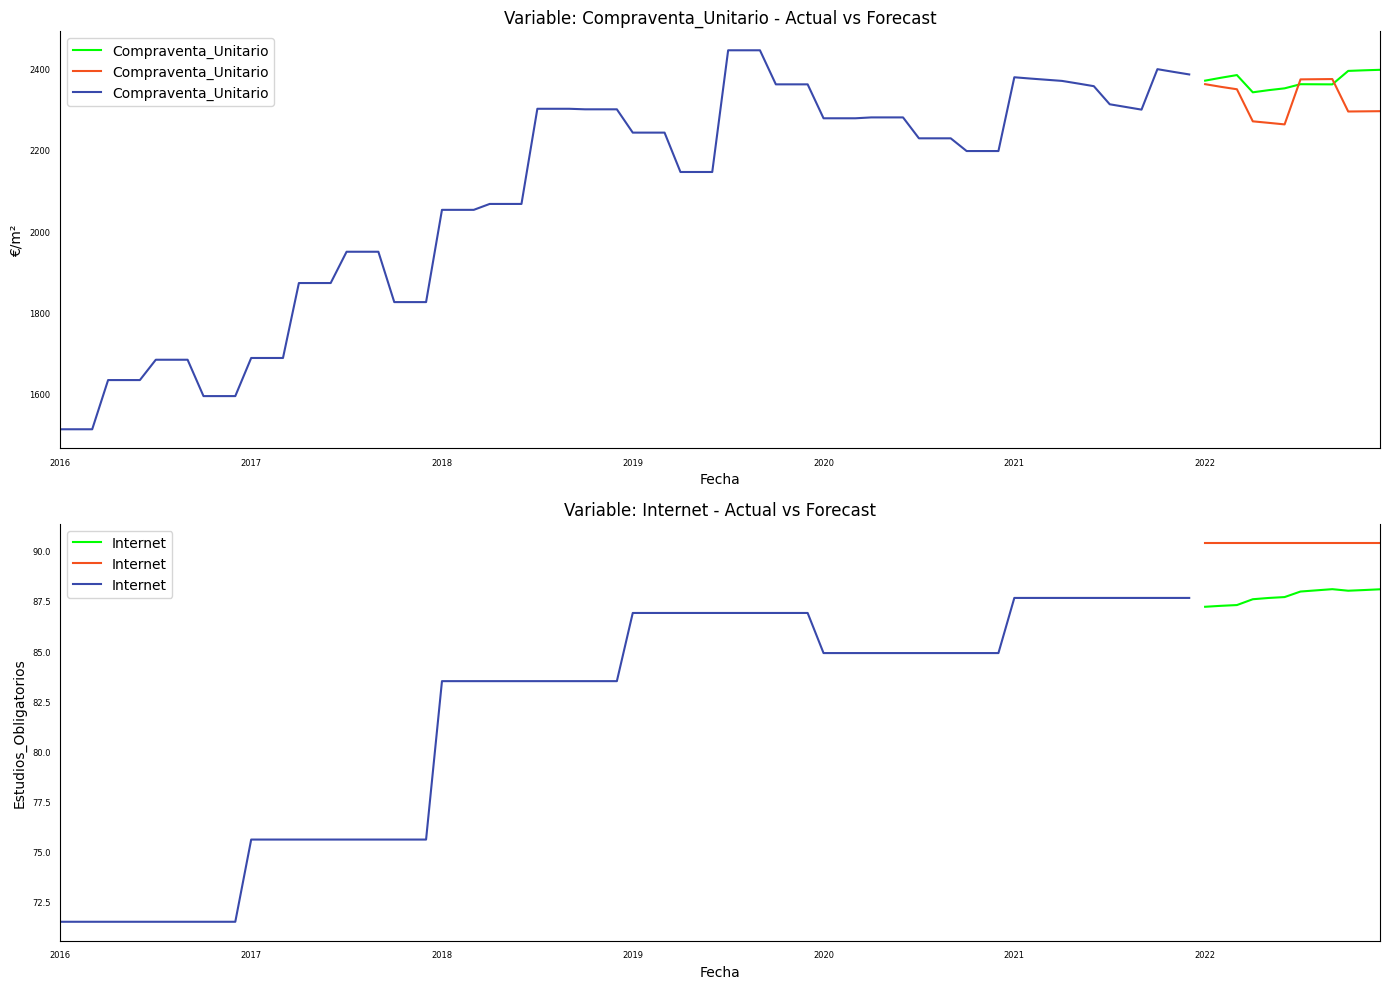

In [85]:
# Actual vs Forecasted Plots
fig, axes = plt.subplots(nrows = int(len(X_train.columns)), ncols = 1, dpi = 100, figsize = (14,10))
mi_lista = ['€/m²', 'Estudios_Obligatorios']

for i, (col,ax) in enumerate(zip(X_train.columns, axes.flatten())):
    pred[col].plot(color = '#00FF00', legend = True, ax = ax).autoscale(axis =' x',tight = True)
    X_test[col].plot(color = '#F4511E', legend = True, ax = ax)
    X_train[col].plot(color = '#3949AB', legend = True, ax = ax)

    ax.set_title('Variable: ' + col + ' - Actual vs Forecast')
    ax.set_ylabel(mi_lista[i])  # Establecer etiqueta del eje y
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')

    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize = 6)

plt.tight_layout()
plt.savefig('actual_forecast.png')
plt.show()

####Evaluando el modelo


In [ ]:
def timeseries_evaluation_metrics_func(y_true, y_pred):

    def mean_absolute_percentage_error(y_true, y_pred):
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print('Evaluation metric results:-')
    print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)}')
    print(f'R2 is : {metrics.r2_score(y_true, y_pred)}',end='\n\n')

In [87]:
for i in ['Compraventa_Unitario','Internet']:
    print(f'Evaluation metric for {i}')
    timeseries_evaluation_metrics_func(X_test[str(i)] , pred[str(i)])

Evaluation metric for Compraventa_Unitario
Evaluation metric results:-
MSE is : 4361.019245498395
MAE is : 53.93000765846117
RMSE is : 66.03801363986045
MAPE is : 2.350650220356128
R2 is : -1.27493051361366

Evaluation metric for Internet
Evaluation metric results:-
MSE is : 7.17232802048228
MAE is : 2.6580440635851894
RMSE is : 2.678120240109148
MAPE is : 2.9403142296296347
R2 is : -3.551564812577387e+28



Para Compraventa_Unitario, las métricas de error como MSE, MAE y RMSE son relativamente moderadas. El MAPE del 2.35% indica una precisión aceptable en términos relativos. Sin embargo, un R² de -1.27 sugiere que el modelo aún es ineficaz y es peor que un modelo que solo usa la media de los datos, indicando una posible especificación incorrecta o variables predictoras inadecuadas.

En el caso de Internet, los valores absolutos de MSE, MAE y RMSE son bajos, sugiriendo errores menores en las predicciones. No obstante, el R² extremadamente negativo de aproximadamente -3.55x10^28 revela serios problemas en el modelo, posiblemente debido a un cálculo incorrecto o a un grave problema de especificación del modelo. El MAPE del 2.94% parece indicar una precisión moderada, pero este valor debe ser interpretado con extrema cautela dada la anomalía en R².

In [88]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
print('Mean absolute error:', mean_absolute_error(X_test, pred))
print('Root mean squared error:', np.sqrt(mean_squared_error(X_test, pred)))

Mean absolute error: 28.29402586102318
Root mean squared error: 46.73431059467379


##Conclusiones

Como conclusiones de realizar un analisis de datos forecasting a los datos de distrito de Nou Barris de Barcelona entre las dos series temporales de Compraventa_unitario y Internet, tenemos que:

- Se ha comprobado que las variables tienen alta correlacion.
- Se ha realizado el test de Cointegracion y se ha demostrado que una de las series Compraventa_unitario esta cointegrada, lo que hace mas adecuado aplicar un modelo VECM, que un modelo VARMA
- Se ha comprobado que la dos series de datos temporales tienen estacionalidad a partir del primer orden de diferenciacion, lo que las hace aptas para aplicar los dos modelos VAR
- Modelo VAR: las metricas de evaluación del modelo VAR, son bastante satisfactorias para la serie temporal de internet y no tanto para la serie temporal de Compraventa_unitario
- Modelo VECM: las metricas de evaluación del modelo VECM, son bastante satisfactorias para la serie temporal de internet y no tanto para la serie temporal de Compraventa_unitario.

Con los datos obtenidos unicamente se ha podido entrenar un modelo VAR.

